# TO-DOs
* For a linear kernel, subspaces
* Implement Dyer's 1/N correction
* Implement other loss functions
* Track kernel features at different timesteps of training

# Documentation (3/26/21)
This notebook implements Batch Gradient Descent of a network of depth $L$ and width $N$ with input dimensions $N_0$. The batch size is $2P$; $P$ points are uniformly drawn from manifolds $M_+, M_-$. Weights are trained to minimize a Mean Squared Error (MSE) loss. 

$$
L(\theta) = P^{-1} \sum_{x_i \in M_+} \left(f(x_i,\theta) - 1\right)^2 + P^{-1}  \sum_{x_i \in M_-} \left(f(x_i,\theta) + 1\right)^2
$$

## 2D Manifolds:
1. Circles (`circles(r1, r2, x1, x2, y1, y2, P)`): two circles with radii $r_1, r_2$ at centers $x_1, y_1$ and $x_2, y_2$.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



KeyboardInterrupt: ignored

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax
import sys
import matplotlib.colors as colors

# dictionary of hyperparameters
h = {
    'N0':2,  # input dim
     'N':1000,  # hidden dim (width)
     'L':1,  # number of hidden layers
     'P':100,  # number of points
     'loss':'mse', # 'mse'=Mean Squared Error, 'hinge', 'bce'=Binary Cross Entropy
     'niter':10000,
     'eta':0.1,
     'lambda2':0.000
}

# SOME UTILITY FUNCTIONS

def make_grid(grid_res, grid_range):
  xs = np.linspace(-grid_range, grid_range, grid_res)
  ys = np.linspace(-grid_range, grid_range, grid_res)
  grid = np.asarray(np.meshgrid(xs, ys)).T.reshape(-1, 2)
  return grid

## Construct the network, loss function, manifolds

In [ ]:
# define a MLP with Relu nonlinearity at each layer
def fully_connected(w, d):
    layers = []
    for i in range(d):
        layers += [stax.Dense(w, W_std = 1, b_std = 0.0), stax.Relu()]
    layers += [stax.Dense(1, W_std=1, b_std = 0.0)]
    return stax.serial(*layers)


init_fn, apply_fn, kernel_fn = fully_connected(h['N'], h['L'])
shape, params = init_fn(random.PRNGKey(2), (h['P'], h['N0']))
apply_fn = jit(apply_fn)
# kernel_fn = jit(kernel_fn, static_argnums=(2,))

if h['loss'] == 'mse':
  def loss(params, inputs, targets):
    return jnp.mean((apply_fn(params, inputs) - targets)**2) + h['lambda2'] * optimizers.l2_norm(params)

elif h['loss'] == 'hinge':
  def loss(params, inputs, targets):
    prod = 1 - apply_fn(params, inputs) * targets
    return jnp.mean(jnp.max(jnp.concatenate(prod, np.zeros_like(targets), axis=1), axis=1)) + h['lambda2'] * optimizers.l2_norm(params) 

def circles(r1, r2, x1, x2, y1, y2, P):
  '''
  Returns a P x 2 array (first P points drawn from one manifold) and a P x 1 array (targets, first P entries are 1, last P entries are -1)
  '''
  thetas = np.linspace(0, 2*np.pi, P)
  circ1 = np.zeros((P, 2))
  circ1[:, 0] = np.cos(thetas) * r1 + x1
  circ1[:, 1] = np.sin(thetas) * r1 + y1

  circ2 = np.zeros((P, 2))
  circ2[:, 0] = np.cos(thetas) * r2 + x2
  circ2[:, 1] = np.sin(thetas) * r2 + y2

  targets = jnp.concatenate((np.ones((P, 1))*1.0, np.ones((P, 1)) * -1.0), axis=0)

  return jnp.concatenate((circ1, circ2), axis=0), targets

X, Y = circles(1, 1, -1, 1, 0, 0, h['P'])

In [ ]:
from tqdm import trange

opt_init, opt_update, get_params = optimizers.sgd(h['eta'])
opt_state = opt_init(params)
v_and_g = jit(jax.value_and_grad(loss))
f_vecs = [] # keep track of function space changes

# append the init function
f_vecs.append(apply_fn(get_params(opt_state), X))

for i in trange(h['niter'], position=0, leave=True):
  value, grads = v_and_g(get_params(opt_state), X, Y)
  opt_state = opt_update(i, grads, opt_state)
  if i % 5000 == 0:
    print(value)
    print(optimizers.l2_norm(grads))
    f_vecs.append(apply_fn(get_params(opt_state), X))
  
# append the final function
f_vecs.append(apply_fn(get_params(opt_state), X))



  0%|          | 0/10000 [00:00<?, ?it/s]

1.0206331


  0%|          | 30/10000 [00:01<2:17:30,  1.21it/s]

0.9919498


 51%|█████     | 5056/10000 [00:18<00:17, 284.89it/s]

0.33525416
0.0016040778


100%|██████████| 10000/10000 [00:35<00:00, 282.14it/s]


In [ ]:
import pickle
pickle.dump({'h':h, 'params':get_params(opt_state)}, open('/asdfasdf', 'wb'))

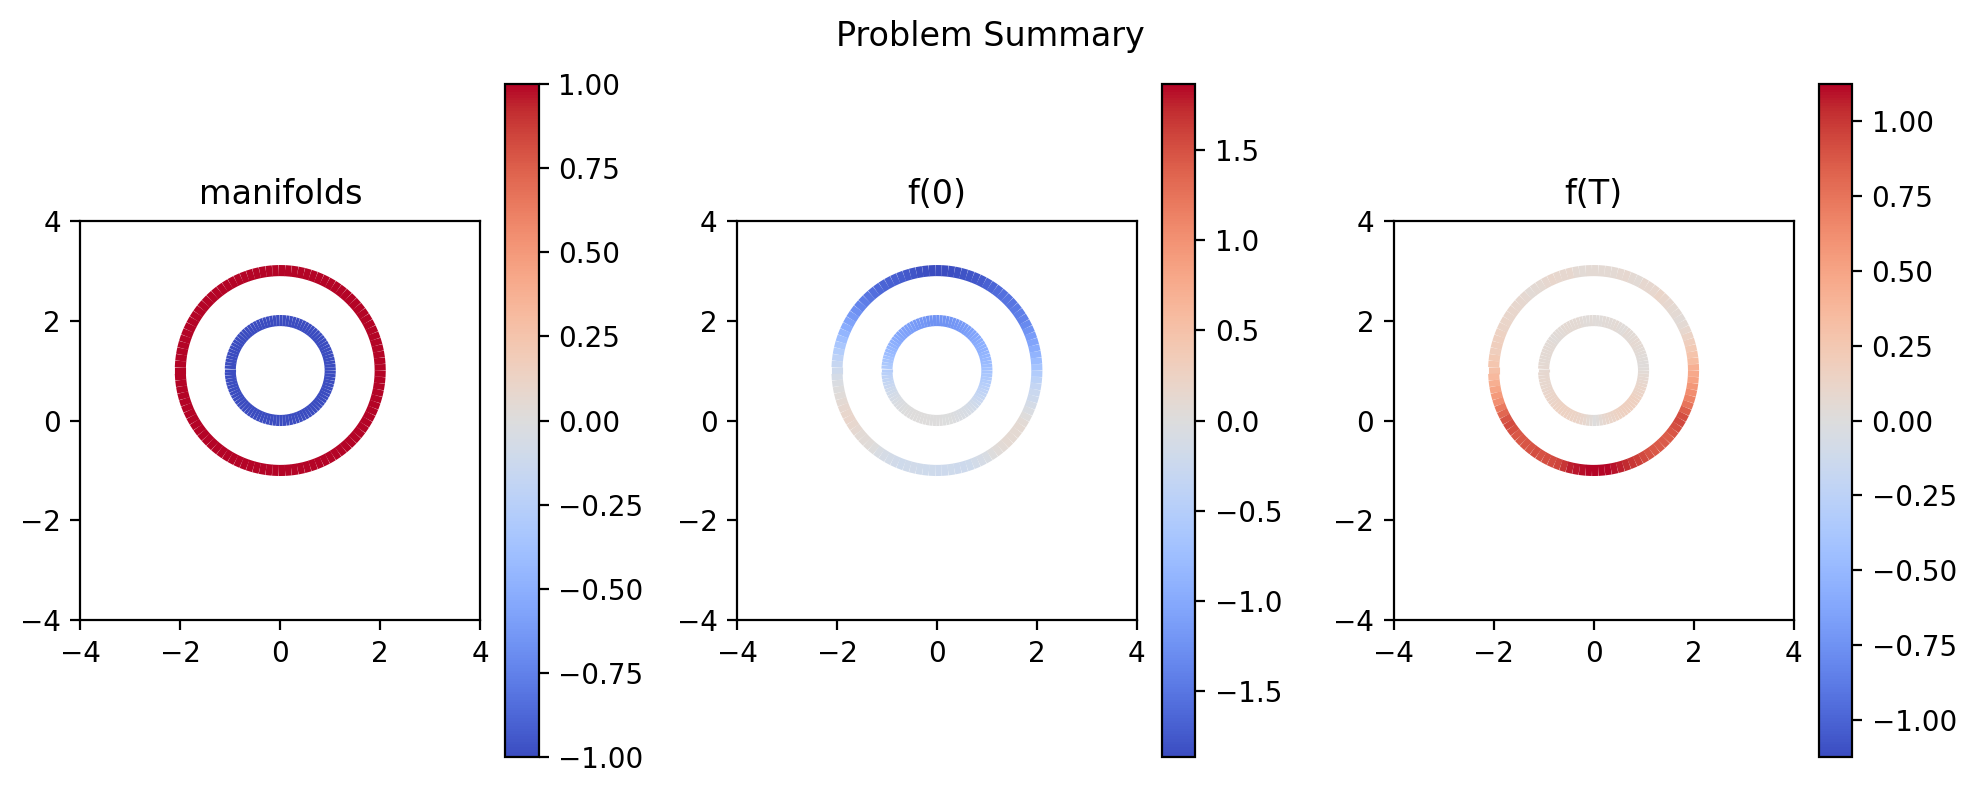

In [ ]:
from matplotlib.collections import LineCollection

eig_ind = 0

def plot_manifolds_with_color(coors, z, P):
  """
  Plot 2 1-manifolds (defined by pairs of coordinates `coors`) with color for each point coded by z. P=num of points per manifold
  """
  z = z.flatten()
  norm = plt.Normalize(-np.abs(z).max(), np.abs(z).max())

  for _coors, _z in [(coors[:P], z[:P]), (coors[P:], z[P:])]:
    points = _coors.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    # Set the values used for colormapping
    lc.set_array(_z)
    lc.set_linewidth(4)
    plt.gca().add_collection(lc)

  plt.xlim(-4, 4)
  plt.ylim(-4, 4)
  plt.gca().set_aspect('equal')
  plt.colorbar(lc, ax=plt.gca())
  return lc

fig, axes = plt.subplots(1, 3, dpi=200, figsize=(10, 4))
axes = axes.ravel()

plt.sca(axes[0])
plot_manifolds_with_color(X, Y.flatten(), h['P'])
plt.title('manifolds')

plt.sca(axes[1])
lc = plot_manifolds_with_color(X, f_vecs[0], h['P'])
plt.title('f(0)')

plt.sca(axes[2])
plot_manifolds_with_color(X, f_vecs[-1], h['P'])
plt.title('f(T)')

plt.suptitle(f'Problem Summary')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

## Evaluate eigenfunctions of the NTK

For a kernel function (empirical or infinite-width) $K(x,x')$, first compute its Gram matrix on the training set ($2P x 2P$). The $i,j$-th element is an estimate of the $j$-th eigenfunction evaluated at the $i$-th point. Eigenfunctions and eigenvalues are sorted in descending order.


(-1.0, 10.0)

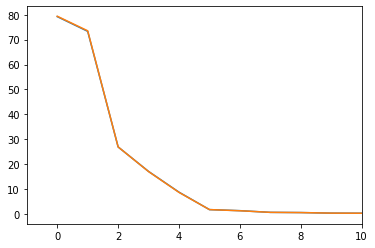

In [ ]:
# Computes values of eigenvectors (induced by the empirical training set probability measure) evaluated on points on the manifolds
def get_eig_fns(ntk_fn, points, params):
  '''
  points: 2P' x N_0 array
  returns: vals: length 2P' array of eigenvalues of the Gram matrix
  vecs: 2P' x 2P' array; the i,j-th element is the j-th eigenfunction evaluated at the i-th point
  '''
  gram_matrix = ntk_fn(points, points, params)
  vals, vecs = jnp.linalg.eigh(gram_matrix)
  return vals[::-1],  vecs[:, ::-1], gram_matrix

empirical_kernel = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
vals0, vecs0, gram0 = get_eig_fns(empirical_kernel, X, params) # initial values
vals1, vecs1, gram1 = get_eig_fns(empirical_kernel, X, get_params(opt_state)) # post-training values

plt.figure()
plt.plot(vals0, label='eigenvalues (init)'); plt.plot(vals1, label='eigenvalues (final)'); plt.xlim(-1, 10)

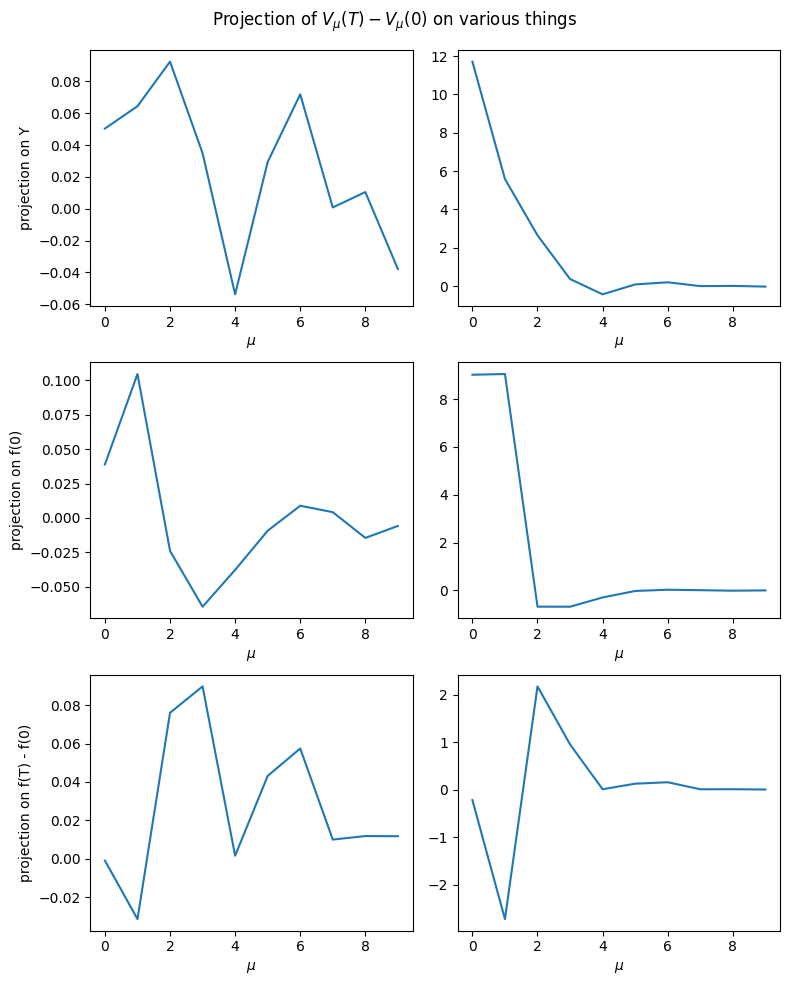

In [ ]:
def get_cos(vectors, target_vector):
  # vectors should be P by N (P=num of vectors), target_vector should have length N
  target_vec = target_vector.reshape(-1, 1)
  normed_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
  return (normed_vectors @ target_vector / np.linalg.norm(target_vector)).flatten()

max_ind = 10

fig, axes = plt.subplots(3, 2, dpi=100, figsize=(8, 10)); axes = axes.ravel()

axes[0].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], Y))
axes[0].set_ylabel('projection on Y')

axes[1].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], Y) * vals0[:max_ind])

axes[2].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], f_vecs[0])); axes[2].set_ylabel('projection on f(0)')

axes[3].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], f_vecs[0]) * vals0[:max_ind])

axes[4].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], f_vecs[-1] - f_vecs[0])); axes[4].set_ylabel('projection on f(T) - f(0)')

axes[5].plot(get_cos((vecs1.T - vecs0.T)[:max_ind], f_vecs[-1] - f_vecs[0]) * vals0[:max_ind])

for ax in axes:
  ax.set_xlabel('$\mu$')

plt.tight_layout()
plt.suptitle('Projection of $V_\mu(T)-V_\mu(0)$ on various things')
plt.subplots_adjust(top=0.94)

Text(0.5, 0.98, 'V_\\mu(0)$')

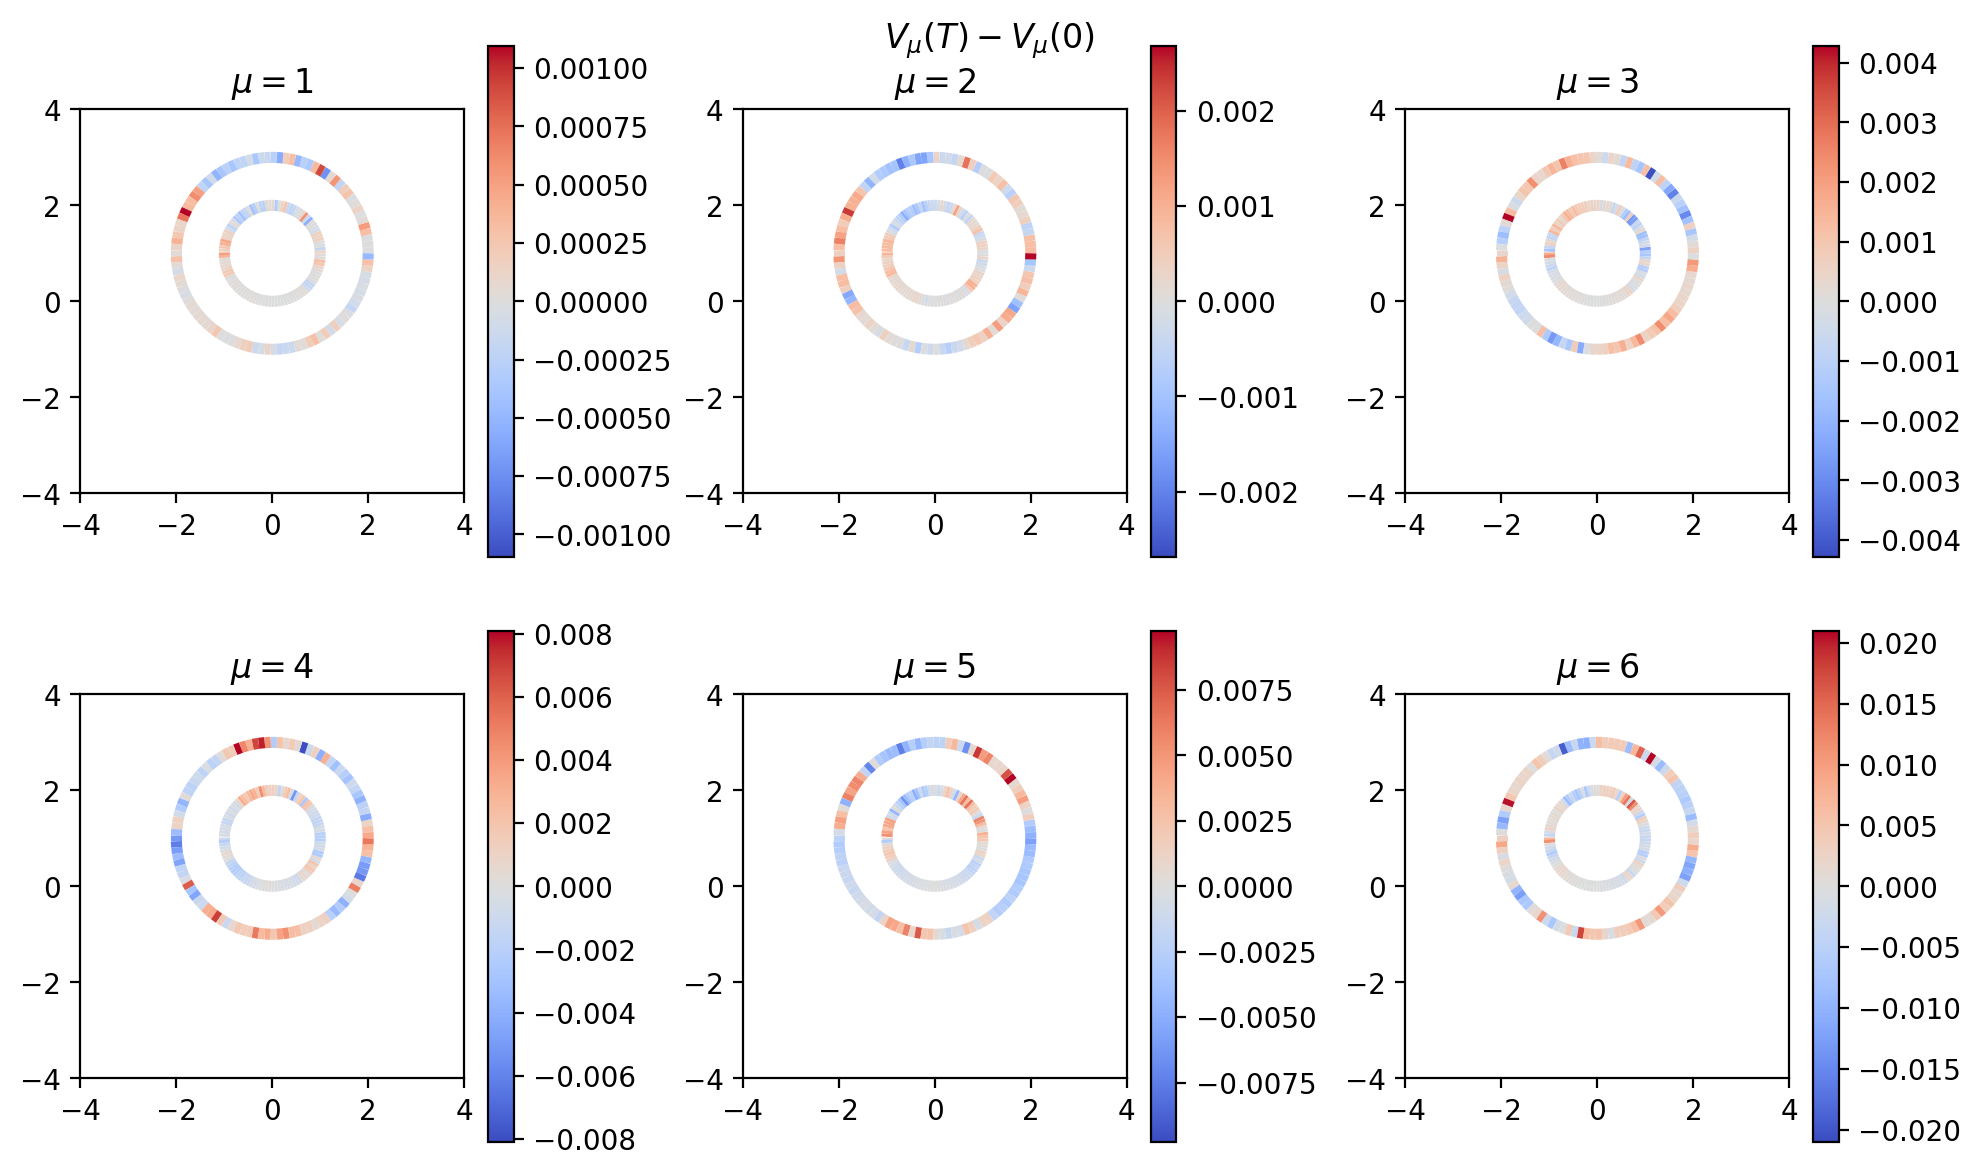

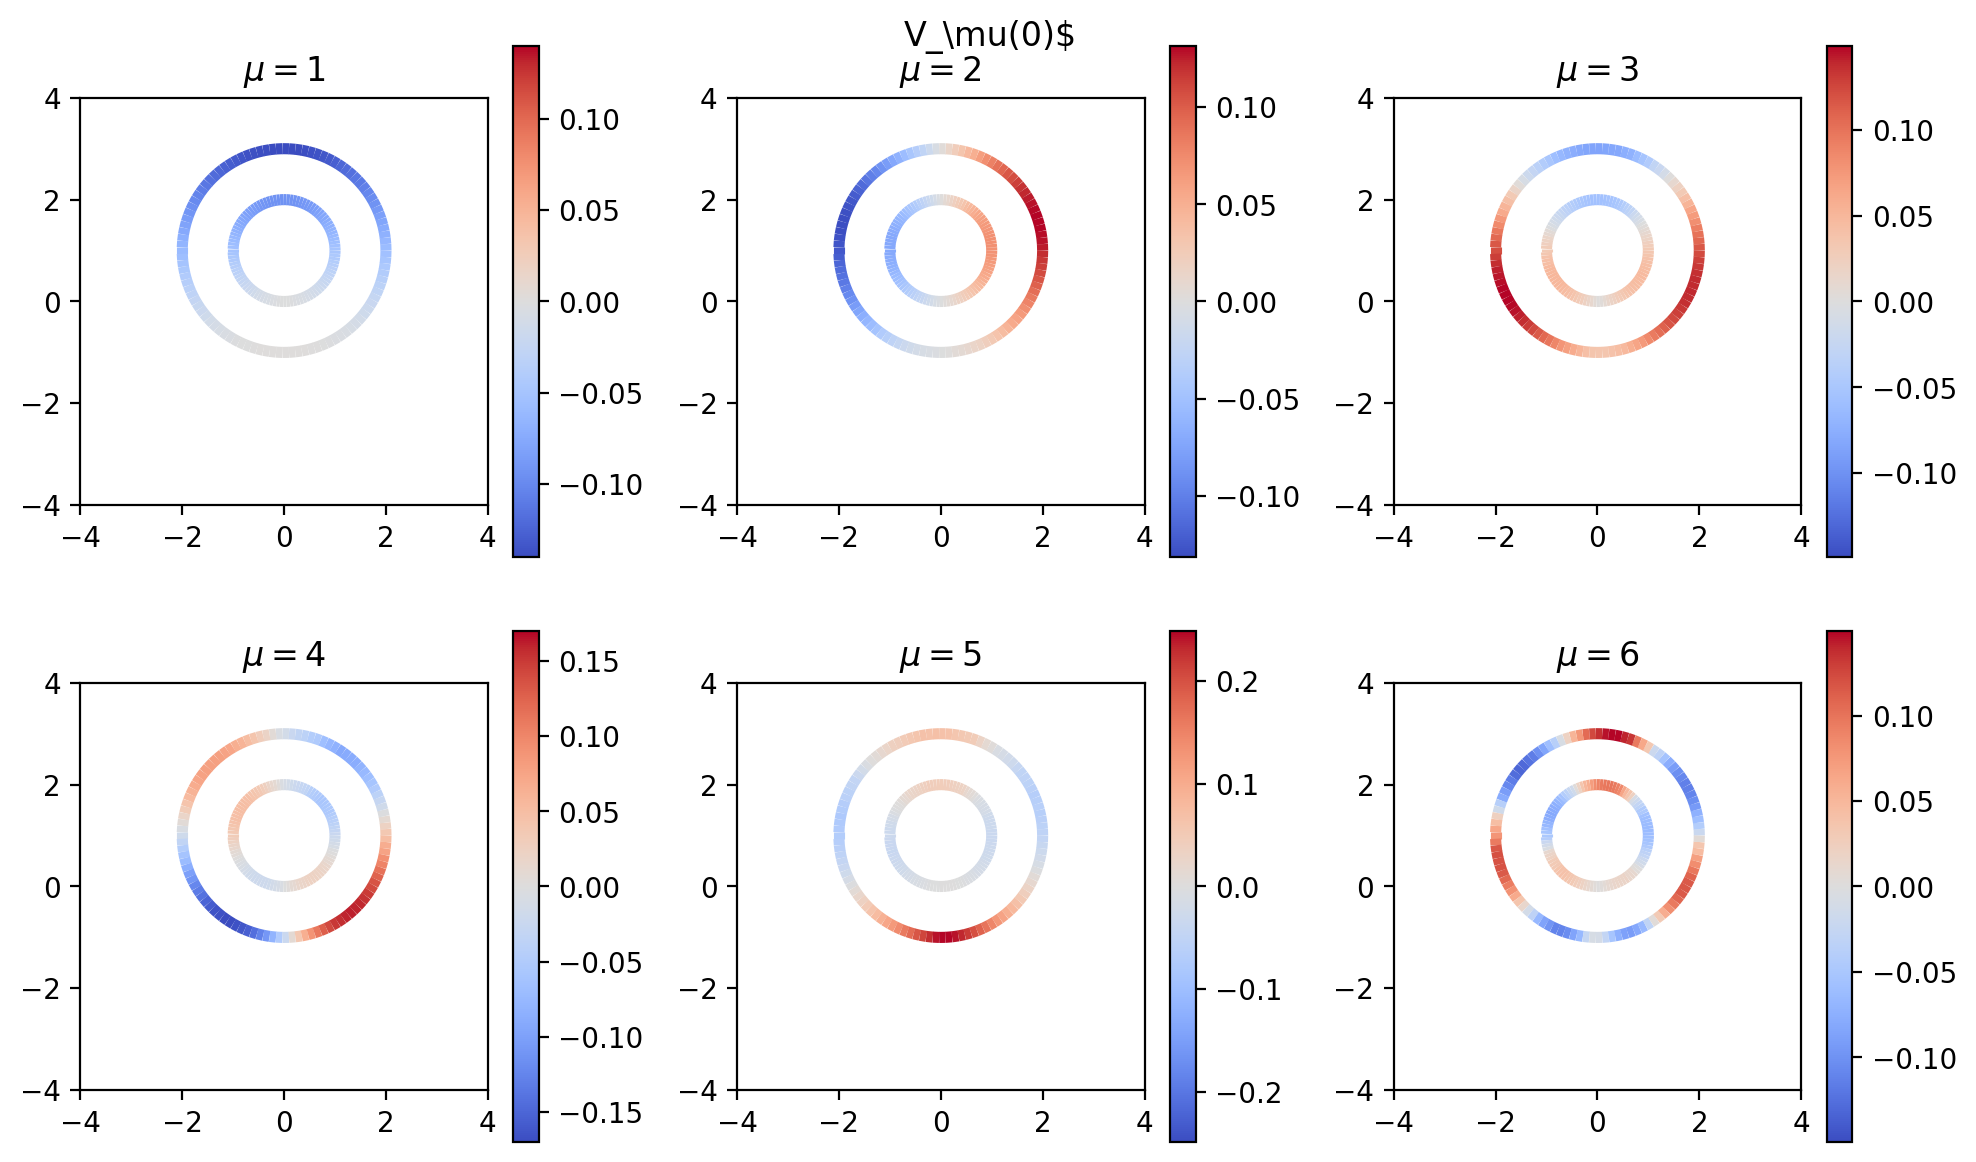

In [ ]:
fig, axes = plt.subplots(2, 3, dpi=200, figsize=(10, 6))
axes = axes.ravel()

for i, ax in enumerate(axes):
  plt.sca(ax)
  plot_manifolds_with_color(X, vecs1[:, i] - vecs0[:, i], h['P'])
  ax.set_xlim(-4, 4)
  ax.set_ylim(-4, 4)
  ax.set_title(f'$\mu={i+1}$')

plt.tight_layout()
plt.suptitle('$V_\mu(T)-V_\mu(0)$')

fig, axes = plt.subplots(2, 3, dpi=200, figsize=(10, 6))
axes = axes.ravel()

for i, ax in enumerate(axes):
  plt.sca(ax)
  plot_manifolds_with_color(X, vecs0[:, i], h['P'])
  ax.set_xlim(-4, 4)
  ax.set_ylim(-4, 4)
  ax.set_title(f'$\mu={i+1}$')

plt.tight_layout()
plt.suptitle('V_\mu(0)$')

## Analysis of changes to the Gram matrix

* Maybe I should look at corrections in f space...


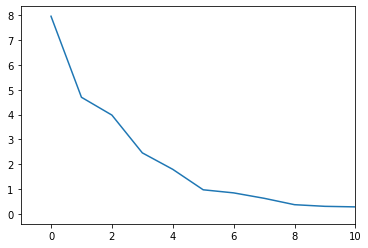

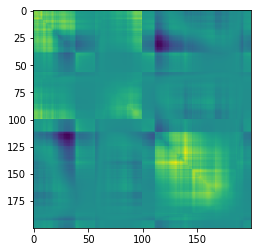

In [ ]:
u, s, v = jnp.linalg.svd(gram1 - gram0)

plt.figure()
plt.plot(s)
plt.xlim(-1, 10)

plt.figure()
plt.imshow(gram1 - gram0)

## Compare f(T) with kernel gradient descent using a fixed kernel


In [ ]:
ntk_infty_gram = kernel_fn(X, None, 'ntk')  # infinite width NTK
ntk_init_gram = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)(X, None, params)  # finite width NTK with initial parameters
t = 10

f0 = f_vecs[0]

for i in range(h['niter']):
  f0 -= ntk_init_gram @ (f0 - Y) * h['eta'] / h['P']
  if i % 1000 == 0:
    print(np.linalg.norm(f0))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


8.639125
12.060029
12.318685
12.436435
12.511234
12.566794
12.610305
12.6452465
12.673864
12.697757


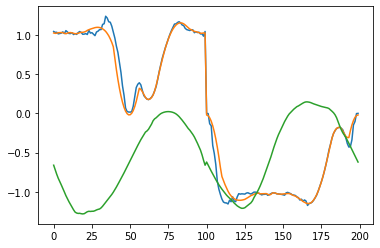

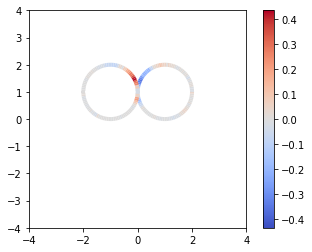

In [ ]:
plt.figure()
plt.plot(f0)
plt.plot(f_vecs[-1])
plt.plot(f_vecs[0])

plt.figure()
plot_manifolds_with_color(X, f_vecs[-1] - f0, h['P'])

(-5.0, 5.0)

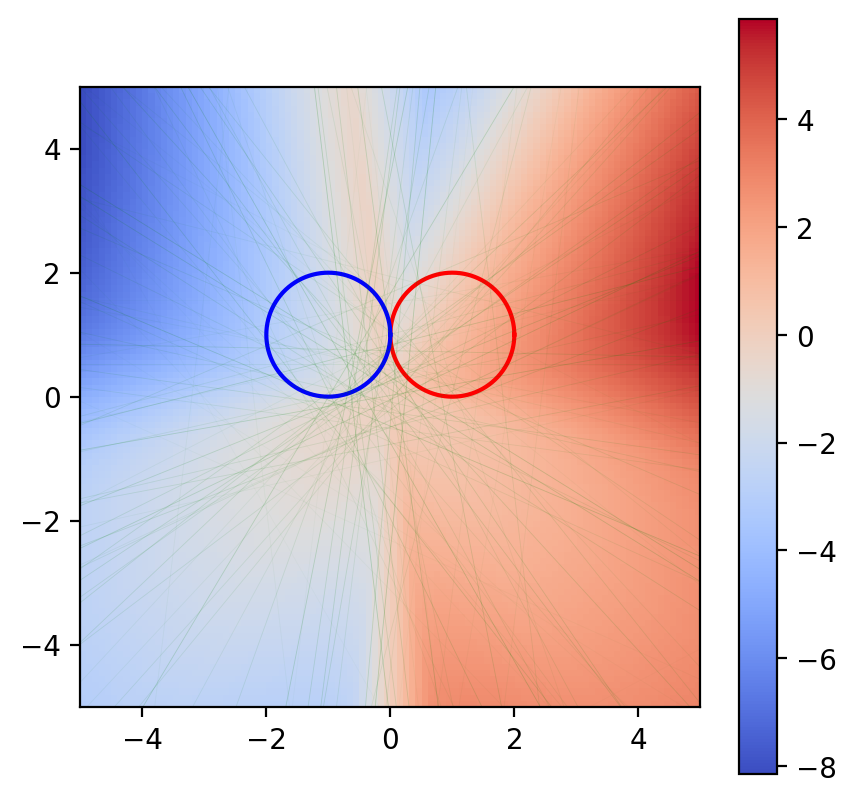

In [ ]:
plt.figure(figsize=(5, 5), dpi=200)


grid_res = 100
plt_rng = 5
xs = np.linspace(-plt_rng, plt_rng, grid_res)
ys = np.linspace(-plt_rng, plt_rng, grid_res)
grid = np.asarray(np.meshgrid(xs, ys)).T.reshape(-1, 2)
grid = np.reshape(np.asarray(grid), [grid_res * grid_res,2])
f_vals = apply_fn(get_params(opt_state), grid).reshape(grid_res, grid_res).T
# f_vals = f_vals[::-1]

plt.imshow(f_vals, extent=(-plt_rng, plt_rng, -plt_rng, plt_rng), cmap='coolwarm')
plt.colorbar()
plt.plot(X[:h['P'], 0], X[:h['P'], 1], color='r')
plt.plot(X[h['P']:, 0], X[h['P']:, 1], color='b')
plt.gca().set_aspect('equal')

w, b = get_params(opt_state)[0]
a = get_params(opt_state)[2][0]
x_1 = np.linspace(-plt_rng, plt_rng, 10)

max_alpha = np.max(np.abs(a).flatten() * np.linalg.norm(w, axis=0))
for i in range(100):
  w_i = w[:, i]
  b_i = b[0, i]
  a_i = a[0, i]
  plt.plot(x_1, (-w_i[0] * x_1 - b_i ) / w_i[1], 'g', alpha=np.linalg.norm(w_i) * np.abs(a_i) / max_alpha, linewidth=0.3)
plt.ylim(-plt_rng, plt_rng)
plt.xlim(-plt_rng, plt_rng)
# plt.plot(mpx, mpy, color='r')
# plt.plot(mmx, mmy, color='b')

(500, 300)